# Measuring the Bias of the Teacher Model

## Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
# import torch

from typing import Callable, Dict
import numpy as np

from collections import defaultdict
from typing import List
import re

import sys
sys.path.insert(0, '..')
from notifier import Notifier

import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
# palette = sns.choose_colorbrewer_palette("qualitative")

In [2]:
notifier = Notifier()
notifier.set_usage(True) # Comment out for no notifications

In [3]:
race_palette = ["b", "r", 'g']
gender_palette = ["c", "m"]

## Functions

In [4]:
def import_predictions(file_path: str, rm_columns: List[str] = [], rename_columns:  Dict[str, str] = {}, parquet_engine: str = "auto", apply_column_funcs: Dict[str, callable] = {}) -> pd.DataFrame:
    """Imports predictions from a file and optionally removes/renames columns. Function documentation generated with Claude Sonnet 4.5
        
        Args:
            file_path (str): Path to the file containing predictions (.csv or .parquet)
            rm_columns (list, optional): List of column names to remove. Defaults to [].
            rename_columns (dict, optional): Dictionary mapping old column names to new names. Defaults to {}.
        
        Returns:
            pd.DataFrame: The processed dataframe with predictions.
        
        Raises:
            ValueError: If file format is unsupported or specified columns don't exist.
        """
    temp_ds = None
    if file_path.endswith('.csv'):
        temp_ds = pd.read_csv(file_path)
    elif file_path.endswith('.parquet'):
        temp_ds = pd.read_parquet(file_path, engine=parquet_engine)
    if temp_ds is None:
        raise ValueError("Unsupported file format. Only .csv and .parquet are supported.")
    
    if len(rm_columns) > 0:
        # Sanity checks for removing columns
        if not all(col in temp_ds.columns for col in rm_columns):
            raise ValueError("One or more columns to remove do not exist in the dataset.")
        # Remove the specified columns
        temp_ds = temp_ds.drop(columns=rm_columns)
    if len(rename_columns) > 0:
        # Sanity checks for renaming columns
        if not all(col in temp_ds.columns for col in rename_columns.keys()):
            raise ValueError("One or more columns to rename do not exist in the dataset.")
        if any(col in temp_ds.columns for col in rename_columns.values()):
            raise ValueError("One or more new column names already exist in the dataset.")
        # Rename the columns
        temp_ds = temp_ds.rename(columns=rename_columns)
    if len(apply_column_funcs) > 0:
        # Sanity checks for applying functions to columns
        if not all(col in temp_ds.columns or col in rename_columns for col in apply_column_funcs.keys()):
            raise ValueError("One or more columns specified for function application do not exist in the dataset.")
        for col, func in apply_column_funcs.items():
            # Check if the function is callable
            if not callable(func):
                raise ValueError(f"The function provided for column '{col}' is not callable.")
            # Set column name after renaming if given initial name
            col_name = col if col in rename_columns else rename_columns[col]
            if col_name not in temp_ds.columns:
                raise ValueError(f"Column '{col}' specified for function application does not exist in the dataset.")
            # Apply the function to the specified column
            temp_ds[col_name] = temp_ds[col_name].apply(func)
    return temp_ds

def import_to_ds(ds: pd.DataFrame, file_path: str, prediction_columns: List[str], column_key: str = 'sentence', rename_columns:  Dict[str, str] = {}, parquet_engine: str = "auto") -> pd.DataFrame:
    """Imports predictions from a file and merges them with the existing dataset. Function documentation generated with Claude Sonnet 4.5
        
        Args:
            ds (pd.DataFrame): The existing dataset to merge predictions into.
            file_path (str): Path to the file containing predictions (.csv or .parquet).
            prediction_column (str): Name of the column containing predictions.
            rename_columns (dict, optional): Dictionary mapping old column names to new names. Defaults to {}.
        
        Returns:
            pd.DataFrame: The dataset with predictions merged in.
        """
    # import the dataframe
    temp_ds = import_predictions(file_path, rename_columns=rename_columns, parquet_engine=parquet_engine)
    merge_key = column_key if column_key in temp_ds.columns else rename_columns.get(column_key, None)
    if merge_key is None:
        raise ValueError(f"Column key '{column_key}' does not exist in the imported dataset.")
    if merge_key not in ds.columns:
        raise ValueError(f"Column key '{column_key}' does not exist in the main dataset.")
    # Set the predicted column name to a renamed column if it is in the renamed columns
    pred_col_names = [col if col not in rename_columns else rename_columns[col] for col in prediction_columns]
    match_columns = set(pred_col_names) - set(temp_ds.columns)
    # Sanity check to ensure all prediction columns exist
    if len(match_columns) > 0:
        raise ValueError(f"{match_columns} columns do not exist in the imported dataset.")
    # Check if any columns already exist in the main dataset
    existing_columns = set(pred_col_names) & set(ds.columns)
    if len(existing_columns) > 0:
        raise ValueError(f"{existing_columns} columns already exist in the main dataset.")
    # Merge the predictions into the main dataset
    temp_ds = temp_ds[[column_key, *pred_col_names]]
    ds = ds.merge(temp_ds, on=column_key, how='left')
    return ds

In [5]:
def compare_differences(df, constants: List[str], variable: str, metric_column: str, curr_info = {}, concat_df=None) -> pd.DataFrame:
    """Compares the differences in means for a variable across different constant categories.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        constants (List[str]): List of column names to keep constant during comparisons.
        variable (str): The variable column name to compare mean values for.
        curr_info (dict, optional): Current information about the constant categories. Defaults to {}.
        concat_df (pd.DataFrame, optional): Dataframe to concatenate results to. Defaults to None.

    Returns:
        pd.DataFrame: A dataframe containing the means for each category of the variable across the constant categories.
    """
    res_df = pd.DataFrame() if concat_df is None else concat_df
    if len(constants) == 0:
        # Base case: calculate means for each category of the variable
        return pd.concat([concat_df,
                          pd.DataFrame([{
                              **curr_info,
                              **{f'{v}_data': df[df[variable] == v][metric_column].to_numpy()#.mean()
                                 for v in df[variable].unique()
                                 if len(df[df[variable] == v]) > 0}
                                 }],)], ignore_index=True)
    # Iterate through each of the values for the columns we want to keep constant among comparisons
    for value in df[constants[0]].unique():
        temp_df = df[df[constants[0]] == value]
        if len(temp_df) == 0:
            continue
        new_constants = constants[1:]
        new_info = curr_info.copy()
        new_info[constants[0]] = value
        res_df = compare_differences(temp_df, new_constants, variable, metric_column, new_info, res_df)
    return res_df

## Analyzing the Accuracy of the Models

In [6]:
teacher_test_df = pd.read_csv("../data/llama3.1/test.csv")
teacher_train_df = pd.read_csv("../data/llama3.1/train.csv")
teacher_test_df['prediction'] = teacher_test_df[['label_0', 'label_1']].to_numpy().argmax(axis=1)
teacher_train_df['prediction'] = teacher_train_df[['label_0', 'label_1']].to_numpy().argmax(axis=1)
print(f"Train:{teacher_train_df.head()}\n")
print(f"Test:{teacher_test_df.head()}\n")

Train:                                                text  label   label_0  \
0  The volleyball genre is strangely overlooked b...      0  0.046020   
1  I got interested in this movie because somebod...      0  0.782700   
2  Sure, I like some indie films. A lot, actually...      0  0.955600   
3  Blademaster is definitely a memorable entry in...      1  0.069030   
4  This World War II Popeye cartoon had some very...      1  0.002823   

   label_1  prediction  
0  0.95400           1  
1  0.21730           0  
2  0.04453           0  
3  0.93100           1  
4  0.99700           1  

Test:                                                text  label   label_0  \
0  This sci-fi great fortunately has little to do...      1  0.001636   
1  Yet another recent comedy that shows that Holl...      0  0.970000   
2  I was looking on Imdbs bottom 100 because i th...      0  0.970000   
3  Bo Derek will not go down in history as a grea...      0  0.925000   
4  During the Civil War, there wer

Llama Teacher Model F1 Score (Train Set): 0.9416


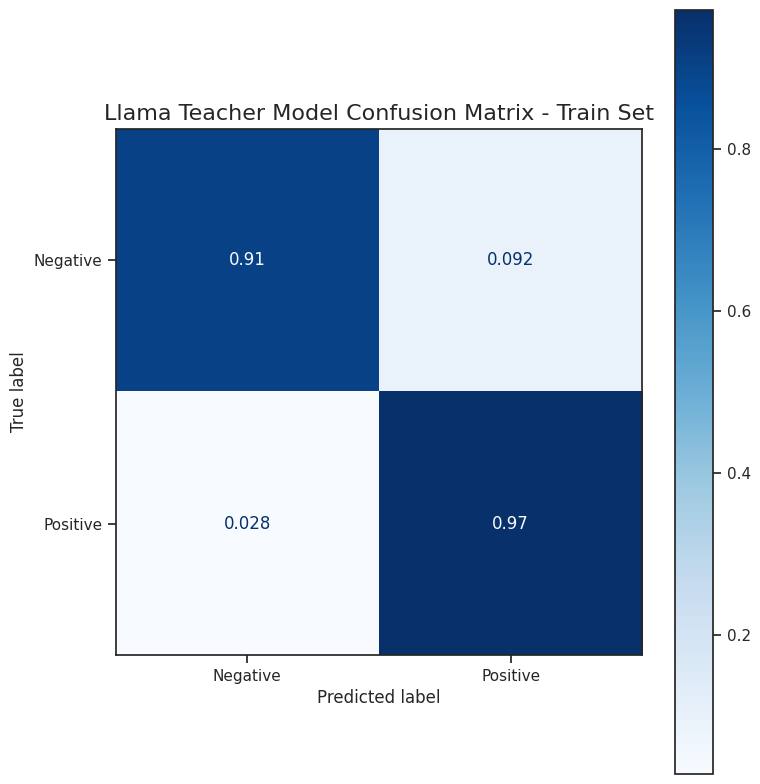

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

train_f1_score = f1_score(
    teacher_train_df['label'], teacher_train_df['prediction']
)

ConfusionMatrixDisplay.from_predictions(
    teacher_train_df['label'], teacher_train_df['prediction'],
    display_labels=["Negative", "Positive"],
    cmap=plt.cm.Blues,
    normalize='true',
    ax = ax
)

ax.set_title("Llama Teacher Model Confusion Matrix - Train Set", fontsize=16)

fig.tight_layout()

fig.savefig("graphs/llama/model_confusion_matrix_train.png", dpi=300)

print(f"Llama Teacher Model F1 Score (Train Set): {train_f1_score:.4f}")

plt.show()

Llama Teacher Model F1 Score (Test Set): 0.9474


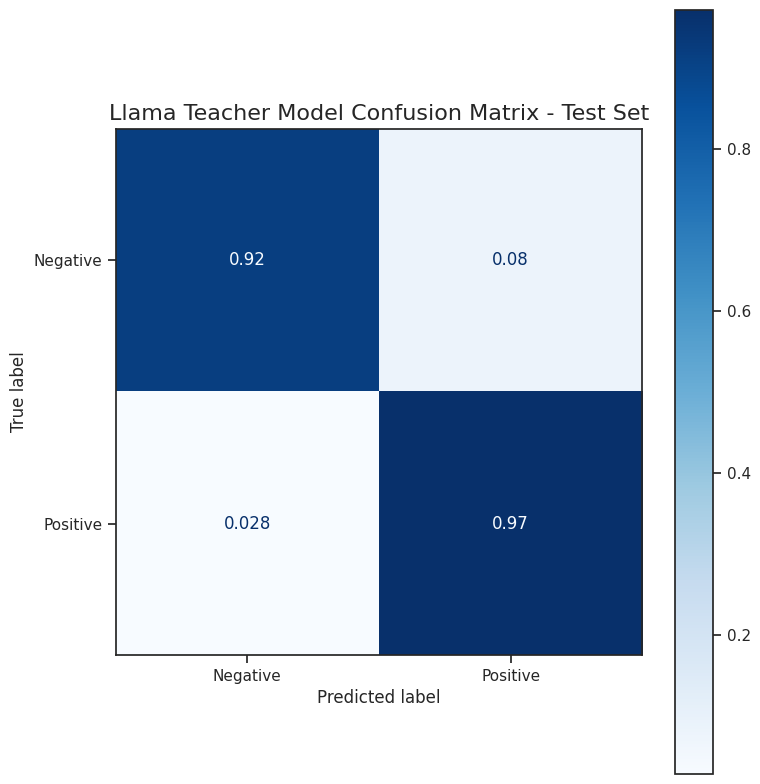

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

test_f1_score = f1_score(
    teacher_test_df['label'], teacher_test_df['prediction']
)


ConfusionMatrixDisplay.from_predictions(
    teacher_test_df['label'], teacher_test_df['prediction'],
    display_labels=["Negative", "Positive"],
    cmap=plt.cm.Blues,
    normalize='true',
    ax = ax
)

ax.set_title("Llama Teacher Model Confusion Matrix - Test Set", fontsize=16)
fig.tight_layout()

fig.savefig("graphs/llama/model_confusion_matrix_test.png", dpi=300)

print(f"Llama Teacher Model F1 Score (Test Set): {test_f1_score:.4f}")

plt.show()

## Running Teacher Model on the EEC Dataset
<style>
pre {
    font-size: 0.8em;
}
</style>
### Teacher Parquet Files
---
##### `datasets/teacher_model_predictions.parquet`
This used a set few shot prompt (the code of which is viable below). This was how the test dataset was created.
```python
def model_prompt(text: str, _) -> str:
    prompt_output = f"""Classify the sentiment of the following texts as either Negative, or Positive.

Text: ...but a lousy film. As Maltin says this was Christopher Lee's attempt to make a serious horror film. Well, it is serious...TOO serious! The plot is silly and slow (something about old people inhabiting the bodies of young children to achieve immortality)...the film is all talk talk talk talk talk talk talk about the same things over and over again. I actually dozed off a few times! The film is sooooo dull! The cast sleepwalks through this with the sole exceptions of Peter Cushing and Lee...but this was probably a labor of love for both (they often complained about horror movies being too violent...well, this has NO violence!). Avoid at all costs...unless you have insomnia...this will put you to sleep!
Sentiment: Negative

Text: Considering it was made on a low budget, THE DAY TIME ENDED manages to make the most of its budget with some surprisingly good special effects work.<br /><br />The story involves a family who are about to move into their solar-powered home in an isolated part of the Mojave Desert in southwestern California, only to find it trashed--by motorcycle vandals, they think. But their youngest daughter (Natasha Ryan) has begun to see mysterious things--a green pyramid, strange humanoid figures, etc. And only recently, the light from a trinary star explosion has caused extremely unusual auroras to show up in the desert skies. Thus the family, led by Jim Davis and Dorothy Malone, finds themselves face-to-face with strange alien forces who have put them in a time-and-space warp.<br /><br />Mixing in elements of 2001: A SPACE ODYSSEY and CLOSE ENCOUNTERS OF THE THIRD KIND, THE DAY TIME ENDED, despite its obvious flaws and uneven acting, remains interesting due to the superb special effects work of David Allen. The desert setting is very appropriate for this film's close encounters; and while the movie cannot really be compared with either Kubrick's or Spielberg's films, THE DAY TIME ENDED is much better than many other 2001/CLOSE ENCOUNTERS knock-offs. I give credit to director John 'Bud' Cardos, whose 1977 thriller KINGDOM OF THE SPIDERS made for an interesting precursor to ARACHNOPHOBIA, for at least trying--and on that basis, I give THE DAY TIME ENDED a 7 out of 10.
Sentiment: Positive

Text: I did a review for this director's fictional recreation about BTK. I had also seen this movie and it was terrible. Please save your money and time. This movie was terrible and this director is untalented. I do not understand how he is funding these movies. They are horrible. I have decided to make sure that I check who the writer, director, and producer are, and if this director's name pops up I will not waste my money. There is nothing worse than renting a movie on a Friday night, making the popcorn, and then realizing you have been duped by creative art on the front of the movie box. Stay away. So I guess I should make up some stuff to fill in the lines? I have always checked IMDb for reviews before, but I think I will not anymore. This is ridiculous. I have been corrected in my reviews far too many times. Not enough lines? You may cancel my account. Your site is a pain.
Sentiment: Negative

Text: {text}
Sentiment: """
    return prompt_output
```
#### `datasets/teacher_rand_example_few_shot_predictions.parquet`
This uses a randomized examples for the few shot (3 examples, can be changed). This is to compare it to a set few shot model. The code for this is seen below. This was how the training dataset was created.
```python
def model_prompt(ex: str, labels: dict) -> str:
    examples = teacher_train_df.sample(n=3)
    output = f"Classify the sentiment of the following texts as either {', '.join(list(labels.values())[:-1])}, or {list(labels.values())[-1]}.\n\n"
    if len(examples) > 0:
        for i, row in examples.iterrows():
            output += f'Text: {row["text"]}\nSentiment: {labels[row["label"]]}\n\n'
    output += f'Text: {ex}\nSentiment: '
    return output
```


#### `datasets/teacher_dolphin_predictions.parquet`

Was run on the Dolphin 3.0 8B Model with the following prompt. 

```python
def model_prompt(text: str, _) -> str:
    prompt_output = f"""Classify the sentiment of the following texts as either Negative, or Positive.

Text: This is such a crappy movie I have no idea how it got on the shelves, they must have paid the movie store to make them put it there, seriously! The story makes absolutely no sense unless you are on some seriously heavy drugs, you would definitely have to be on something in order to watch this total piece of garbage, so much so that you would not care what was on the TV because you're almost in a coma. The writing sounds like it was done by a 5-year-old and the acting is worse than grade school plays. The hideous special effects they were trying to do look so stupid, what did they spend a whole $5 to make the entire movie, it looks like it! Oh my, that scene with the old woman who has an 80's hairdo and the ugly girls in the rubber suits, me and my friends laughed so hard. Did someone actually think it was a good idea to make this into a movie? I find that hard to believe!
Sentiment: Negative

Text: Wow! I have seen so many bad low budget films lately, but this one is great. The very realistic portrayal of police life in a city on the East German coast is a strong contrast to other crime movies or series. I loved the main actress and the absolute rejection of any prevalent cliché about the police. This film is realistic like a documentation and entertaining like a drama at the same time. A perfect tradeoff!
Sentiment: Positive

Text: I've seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it's a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson's assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it's rare to find a film from the Me Decade that actually can make you think. This is one I'd love to see on the big screen, because even in a widescreen presentation, I don't think the overall scope of this film would receive its due. Check it out.
Sentiment: Positive

Text: {text}
Sentiment: """
    return prompt_output
```

In [9]:
# from hugging_face_model import HFModel

# llama_31 = HFModel()

# llama_31.load_model("dphn/Dolphin3.0-Llama3.1-8B")

# llama_31.set_labels({0: "Negative", 1: "Positive"})
# # Randome sample prompt function
# def model_prompt(text: str, _) -> str:
#     prompt_output = f"""Classify the sentiment of the following texts as either Negative, or Positive.

# Text: This is such a crappy movie I have no idea how it got on the shelves, they must have paid the movie store to make them put it there, seriously! The story makes absolutely no sense unless you are on some seriously heavy drugs, you would definitely have to be on something in order to watch this total piece of garbage, so much so that you would not care what was on the TV because you're almost in a coma. The writing sounds like it was done by a 5-year-old and the acting is worse than grade school plays. The hideous special effects they were trying to do look so stupid, what did they spend a whole $5 to make the entire movie, it looks like it! Oh my, that scene with the old woman who has an 80's hairdo and the ugly girls in the rubber suits, me and my friends laughed so hard. Did someone actually think it was a good idea to make this into a movie? I find that hard to believe!
# Sentiment: Negative

# Text: Wow! I have seen so many bad low budget films lately, but this one is great. The very realistic portrayal of police life in a city on the East German coast is a strong contrast to other crime movies or series. I loved the main actress and the absolute rejection of any prevalent cliché about the police. This film is realistic like a documentation and entertaining like a drama at the same time. A perfect tradeoff!
# Sentiment: Positive

# Text: I've seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it's a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson's assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it's rare to find a film from the Me Decade that actually can make you think. This is one I'd love to see on the big screen, because even in a widescreen presentation, I don't think the overall scope of this film would receive its due. Check it out.
# Sentiment: Positive

# Text: {text}
# Sentiment: """
#     return prompt_output
# llama_31.set_prompt(model_prompt)

In [10]:
# # Correct format for downloading raw files from Hugging Face datasets
# ds = pd.read_parquet(
#     "https://huggingface.co/api/datasets/peixian/equity_evaluation_corpus/parquet/first_domain/train/0.parquet"
# )

# label_prob = []
# for sentence in tqdm(ds['sentence']):
#     probs = llama_31.predict(sentence)
#     label_prob.append(probs.numpy())
# # Convert to numpy array and transpose to slice correctly
# label_prob = np.array(label_prob).T
# # Add the probabilities to the dataframe
# ds['0'], ds['1'] = label_prob
# notifier.send_notification("Finished Running through Teacher Model Predictions")
# # Save the dataframe with predictions
# ds.to_parquet("datasets/teacher_dolphin_predictions.parquet")
# notifier.send_notification("Saved Teacher Model Predictions to Parquet File")
# ds.head()

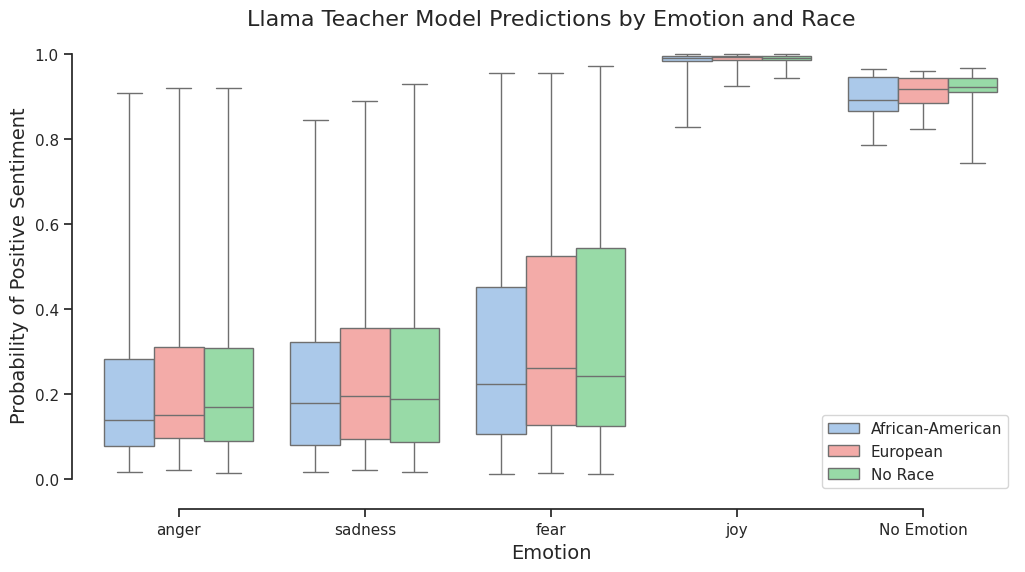

In [11]:
ds = import_predictions("datasets/teacher_model_predictions.parquet", rm_columns=['0'], rename_columns={"1": "prediction"})

ds['gender'] = ds['gender'].replace('', 'No Gender')
ds['race'] = ds['race'].replace('', 'No Race')
ds['emotion'] = ds['emotion'].replace('', 'No Emotion')

fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    x="emotion", y="prediction",
    hue="race", palette=race_palette,
    data=ds,
    whis=(0, 100),
    ax=ax
)

sns.despine(offset=10, trim=True)

ax.legend(loc='lower right')
ax.set_title("Llama Teacher Model Predictions by Emotion and Race", fontsize=16)
ax.set_xlabel("Emotion", fontsize=14)
ax.set_ylabel("Probability of Positive Sentiment", fontsize=14)

ax.legend(loc='lower right')

fig.savefig("graphs/llama/model_predictions_by_emotion_and_race.png", dpi=300)

# notifier.send_image("Llama Teacher Model Predictions by Emotion and Race", "graphs/llama/model_predictions_by_emotion_and_race.png")

plt.show()

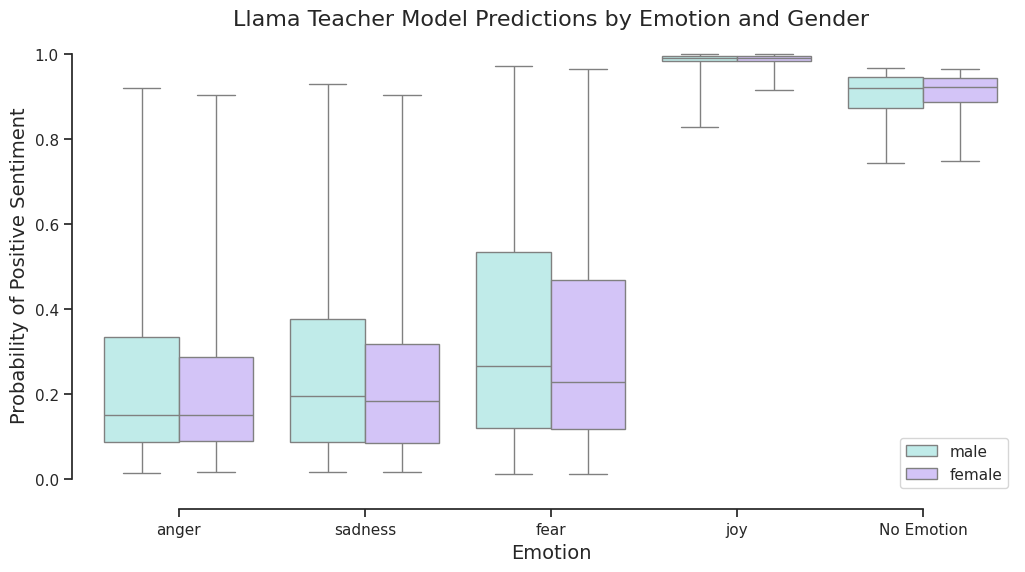

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    x="emotion", y="prediction",
    hue="gender", palette=gender_palette,
    data=ds,
    whis=(0, 100),
    ax=ax
)

sns.despine(offset=10, trim=True)

ax.legend(loc='lower right')
ax.set_title("Llama Teacher Model Predictions by Emotion and Gender", fontsize=16)
ax.set_xlabel("Emotion", fontsize=14)
ax.set_ylabel("Probability of Positive Sentiment", fontsize=14)

fig.savefig("graphs/llama/model_predictions_by_emotion_and_gender.png", dpi=300)

# notifier.send_image("Llama Teacher Model Predictions by Emotion and Gender", "graphs/llama/model_predictions_by_emotion_and_gender.png")
plt.show()

## Analyzing the EEC Datatset Results

Import EEC Prediction Datasets and Combine them into one DataFrame for Easy comparison

In [13]:
def graph_ratios_by_variable(ds: pd.DataFrame, y_column: str, variable: str, title_start: str, palette: List[str], save_path: str):
    """Graphs the ratios of distilled to baseline model predictions by a specified variable.

    Args:
        ds (pd.DataFrame): The dataframe containing the data.
        y_column (str): The column name for the y-axis values.
        variable (str): The variable column name to compare ratios for.
        title_start (str): The starting string for the plot title.
        palette (List[str]): The color palette for the plot.
        save_path (str): The file path to save the graph.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_yscale('log')

    sns.boxplot(
        x="emotion", y=y_column,
        hue=variable, palette=palette,
        data=ds,
        whis=(0, 100),
        ax=ax
    )

    sns.despine(offset=10, trim=True)

    ax.legend()#loc='upper right')

    ax.set_title(f"{title_start} Prediction Ratios by Emotion and {variable.capitalize()}", fontsize=16)
    ax.set_ylabel("Distilled / Baseline Positive Prediction Ratio", fontsize=14)
    ax.set_xlabel("Emotion", fontsize=14)

    ax.grid(axis='y')

    fig.tight_layout()

    fig.savefig(save_path, dpi=300)

In [14]:
def graph_differences_by_variable(ds: pd.DataFrame, y_column: str, variable: str, title_start: str, palette: List[str], save_path: str):
    """Graphs the differences of distilled to baseline model predictions by a specified variable.

    Args:
        ds (pd.DataFrame): The dataframe containing the data.
        y_column (str): The column name for the y-axis values.
        variable (str): The variable column name to compare differences for.
        title_start (str): The starting string for the plot title.
        palette (List[str]): The color palette for the plot.
        save_path (str): The file path to save the graph.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.boxplot(
        x="emotion", y=y_column,
        hue=variable, palette=palette,
        data=ds,
        whis=(0, 100),
        ax=ax
    )

    sns.despine(offset=10, trim=True)

    ax.legend()

    ax.set_title(f"{title_start} Prediction Differences by Emotion and {variable.capitalize()}", fontsize=16)
    ax.set_ylabel("Distilled - Baseline Positive Prediction Difference", fontsize=14)
    ax.set_xlabel("Emotion", fontsize=14)

    ax.grid(axis='y')

    fig.tight_layout()

    fig.savefig(save_path, dpi=300)

In [15]:
ds = import_predictions("datasets/teacher_model_predictions.parquet", rm_columns=['0'], rename_columns={"1": "llama"})
ds = import_to_ds(ds, "datasets/eec_predictions_bow_baseline.csv", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "bow_baseline"})
ds = import_to_ds(ds, "datasets/eec_predictions_bow_distilled1.csv", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "bow_distilled"})
ds = import_to_ds(ds, "datasets/eec_predictions_cnn_baseline.csv", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "cnn_baseline"})
ds = import_to_ds(ds, "datasets/eec_predictions_cnn_distilled1.csv", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "cnn_distilled"})
# ds = import_to_ds(ds, "datasets/distilbert_trained_EEC_predictions.parquet", prediction_columns=["pos_prob"], rename_columns={"pos_prob": "distilled_bert", "Sentence": "sentence"})
# ds = import_to_ds(ds, "datasets/distilbert_eec_baseline_predictions.csv", prediction_columns=["prediction"], rename_columns={"prediction": "base_bert_1"})


ds['gender'] = ds['gender'].replace('', 'No Gender')
ds['race'] = ds['race'].replace('', 'No Race')
ds['emotion'] = ds['emotion'].replace('', 'No Emotion')

ds.head(5)

,sentence,template,person,gender,race,emotion,emotion word,llama,bow_baseline,bow_distilled,cnn_baseline,cnn_distilled
0,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,0.247964,0.000909,0.017086,0.351172,0.508674
1,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,0.236573,0.051289,0.025428,0.473151,0.471639
2,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated,0.161325,0.000872,0.000267,0.315851,0.352700
3,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged,0.259896,0.018262,0.020630,0.476395,0.523213
4,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed,0.191960,0.000137,0.000748,0.461313,0.502585


In [16]:
model_cols = ds.columns[~ds.columns.isin(['sentence', 'template', 'person', 'gender', 'race', 'emotion', 'emotion word'])].tolist()

ds_model_cols = ds.melt(
        id_vars=['sentence', 'template', 'person', 'gender', 'race', 'emotion', 'emotion word'],
        value_vars=model_cols,
        var_name='model',
        value_name='prediction'
        )
ds_model_cols.head(5)

,sentence,template,person,gender,race,emotion,emotion word,model,prediction
0,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,llama,0.247964
1,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,llama,0.236573
2,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated,llama,0.161325
3,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged,llama,0.259896
4,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed,llama,0.191960


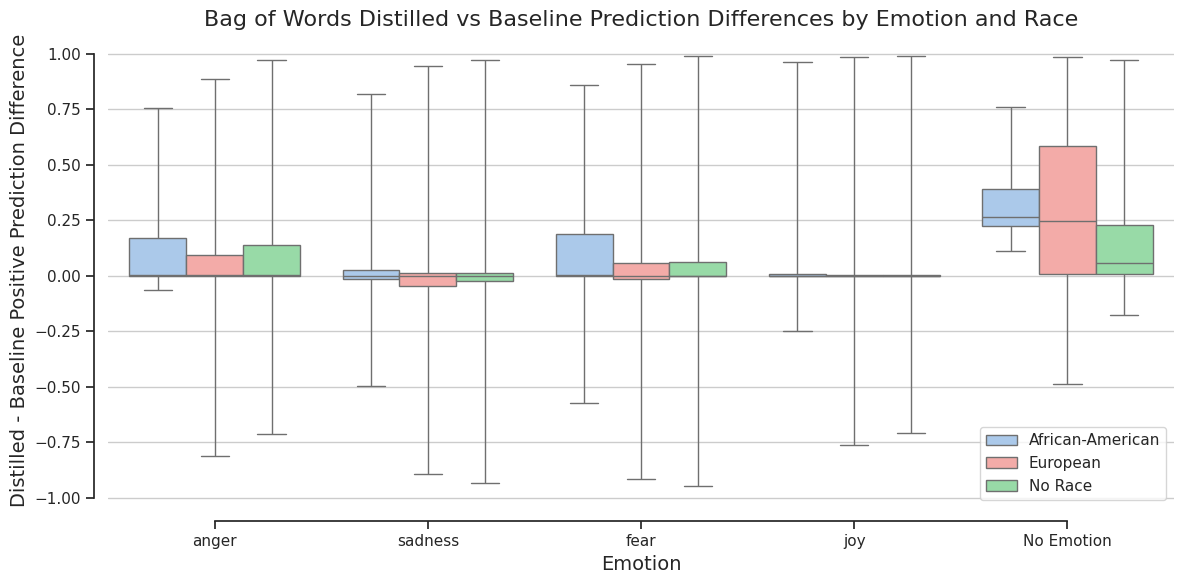

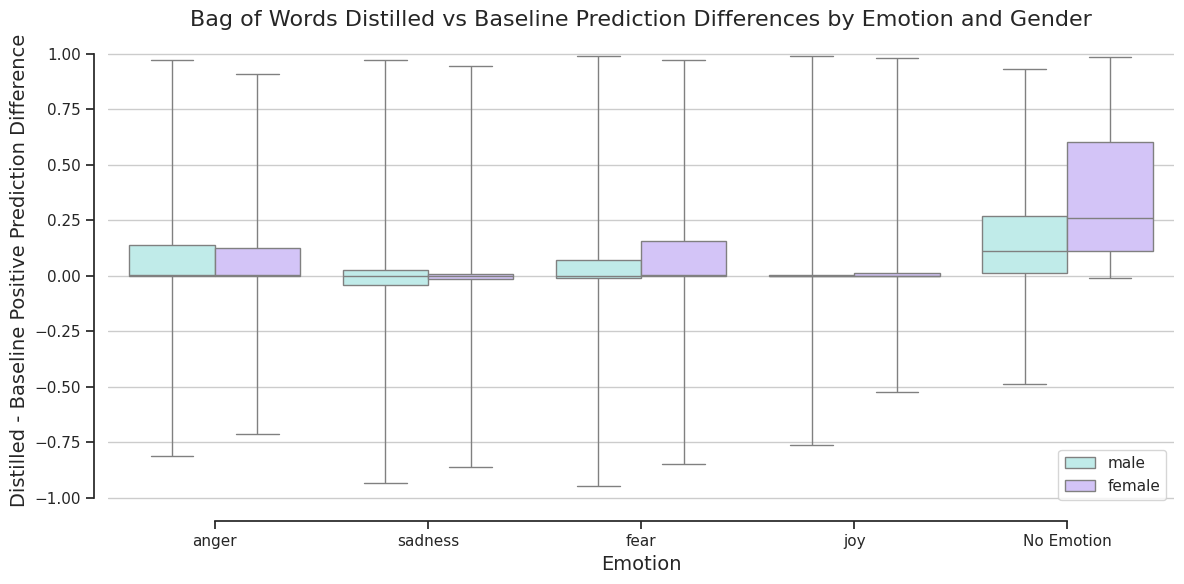

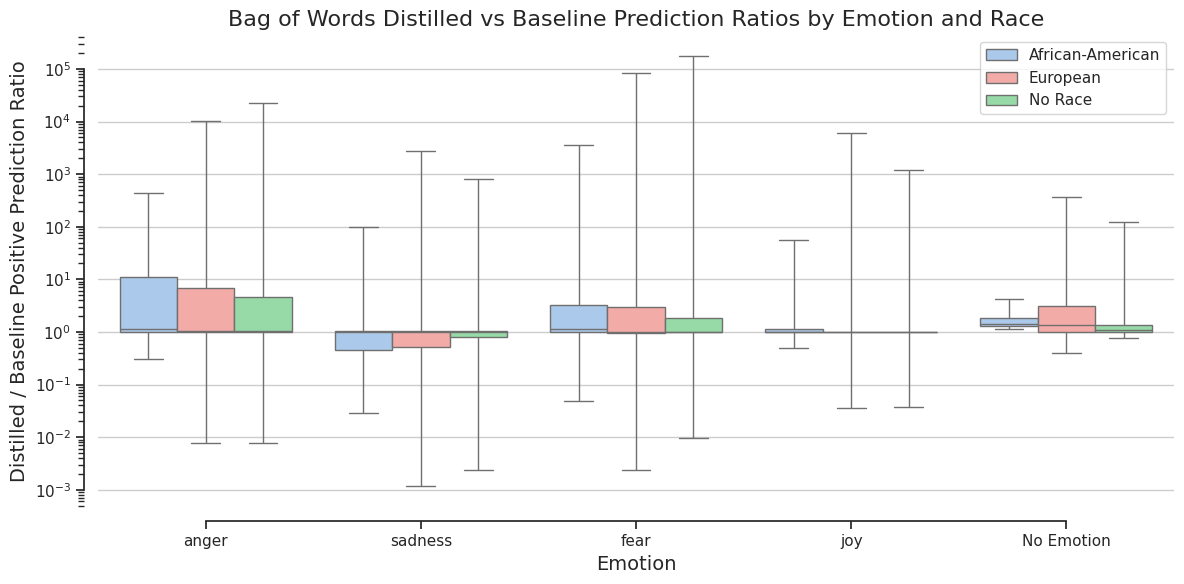

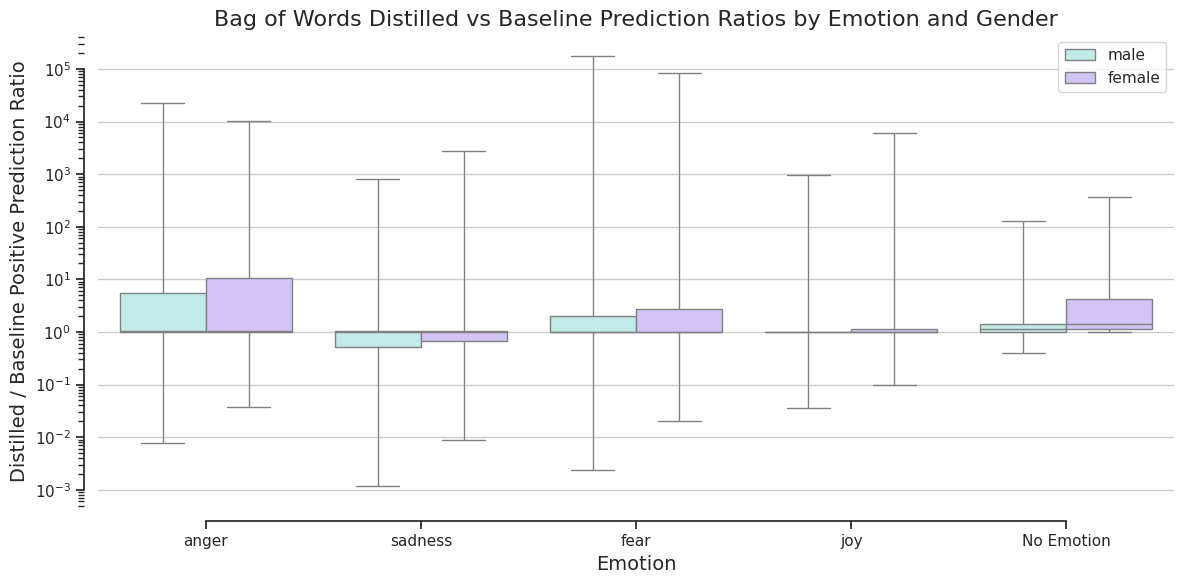

In [17]:
# Get ratios between llama and bow distilled
ds['bow_distil_ratio'] = ds['bow_distilled'] / ds['bow_baseline']
# Get differences between llama and bow distilled
ds['bow_distil_diff'] = ds['bow_distilled'] - ds['bow_baseline']


graph_differences_by_variable(ds, "bow_distil_diff", "race", "Bag of Words Distilled vs Baseline", race_palette, "graphs/bow/distilled_vs_baseline_differences_by_emotion_and_race.png")
graph_differences_by_variable(ds, "bow_distil_diff", "gender", "Bag of Words Distilled vs Baseline", gender_palette, "graphs/bow/distilled_vs_baseline_differences_by_emotion_and_gender.png")

graph_ratios_by_variable(ds, "bow_distil_ratio", "race", "Bag of Words Distilled vs Baseline", race_palette, "graphs/bow/distilled_vs_baseline_ratios_by_emotion_and_race.png")
graph_ratios_by_variable(ds, "bow_distil_ratio", "gender", "Bag of Words Distilled vs Baseline", gender_palette, "graphs/bow/distilled_vs_baseline_ratios_by_emotion_and_gender.png")

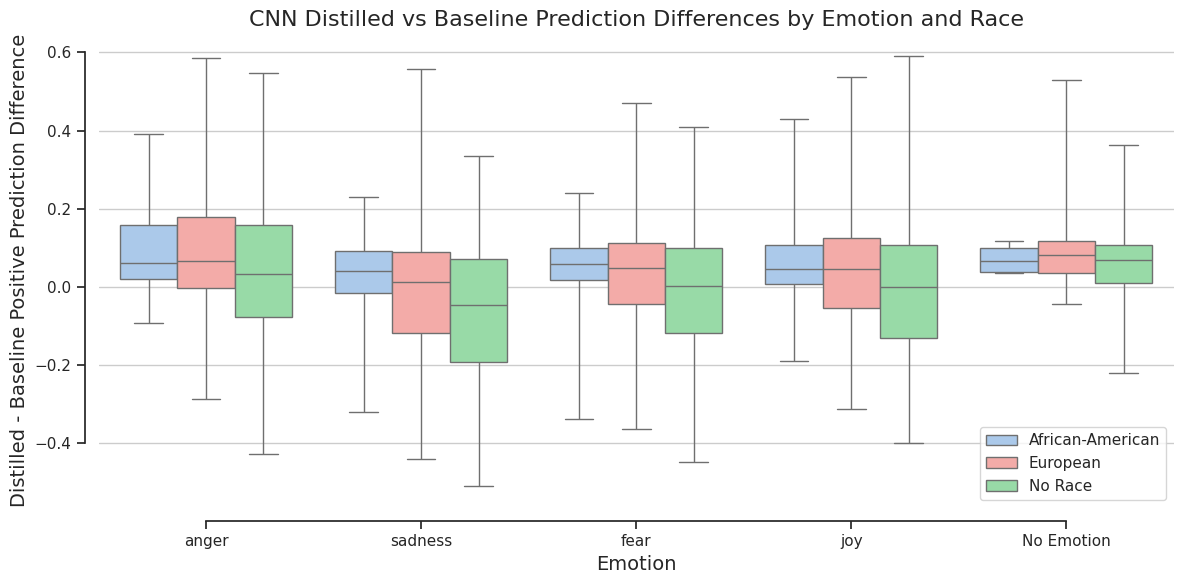

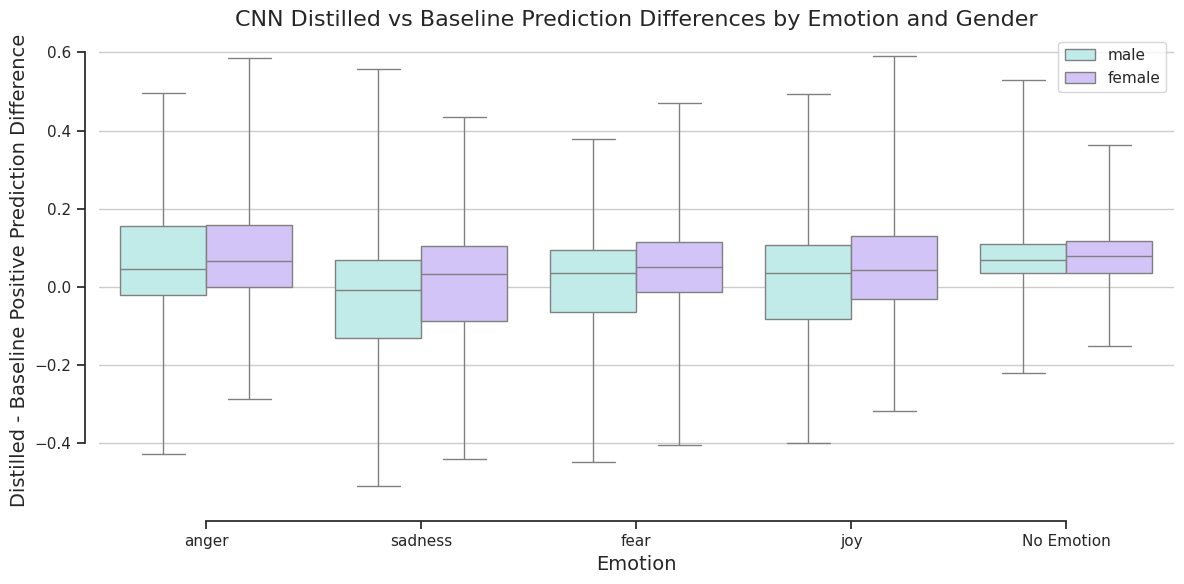

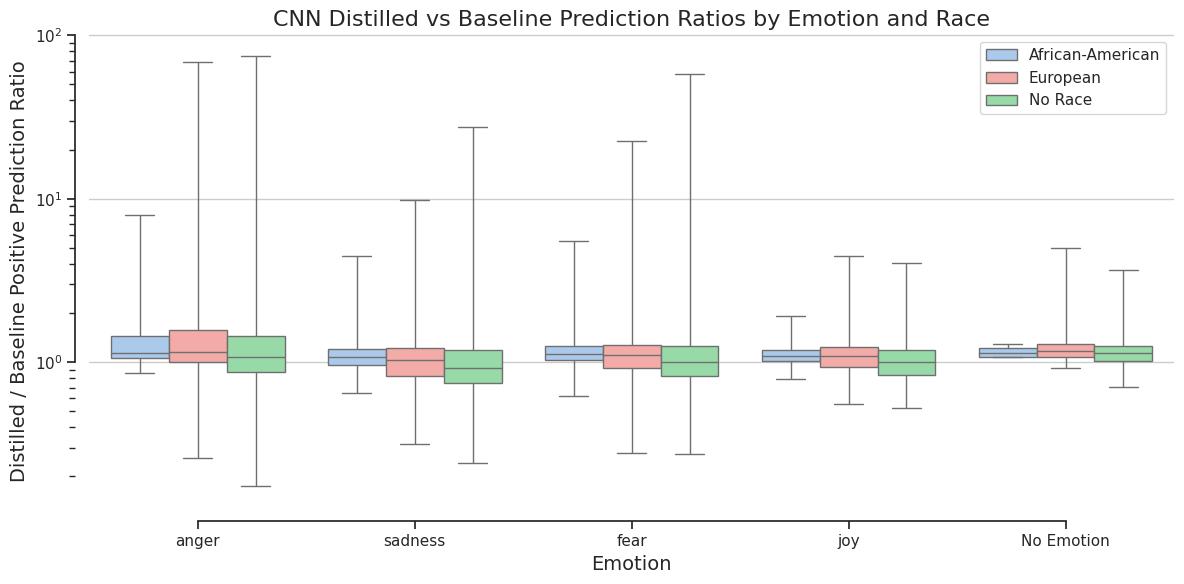

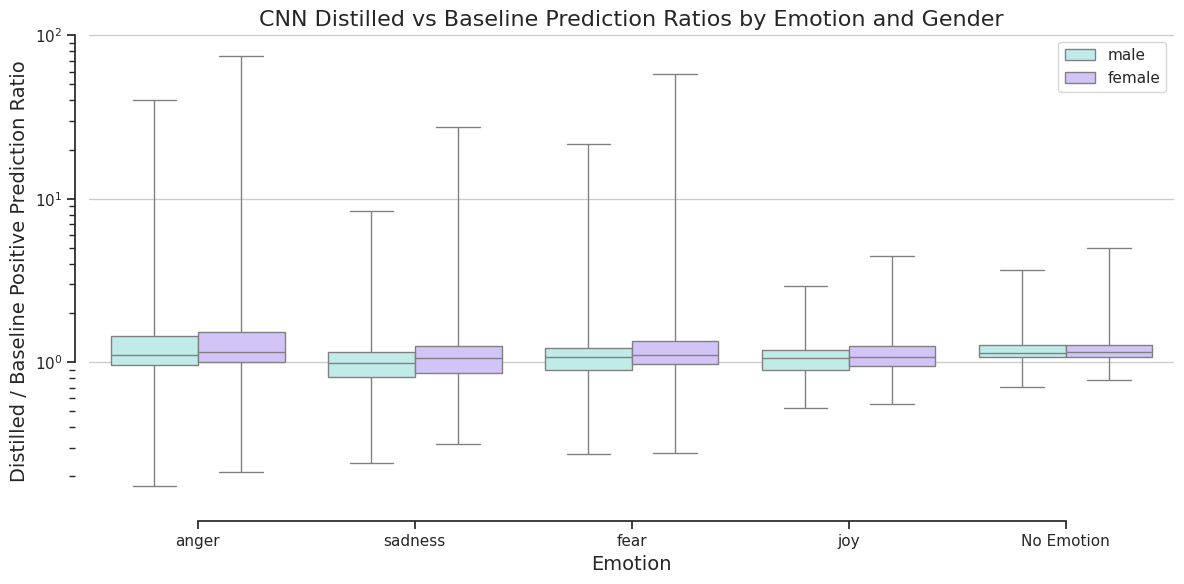

In [18]:
ds['cnn_distil_diff'] = ds['cnn_distilled'] - ds['cnn_baseline']
ds['cnn_distil_ratio'] = ds['cnn_distilled'] / ds['cnn_baseline']

graph_differences_by_variable(ds, "cnn_distil_diff", "race", "CNN Distilled vs Baseline", race_palette, "graphs/cnn/distilled_vs_baseline_differences_by_emotion_and_race.png")
graph_differences_by_variable(ds, "cnn_distil_diff", "gender", "CNN Distilled vs Baseline", gender_palette, "graphs/cnn/distilled_vs_baseline_differences_by_emotion_and_gender.png")

graph_ratios_by_variable(ds, "cnn_distil_ratio", "race", "CNN Distilled vs Baseline", race_palette, "graphs/cnn/distilled_vs_baseline_ratios_by_emotion_and_race.png")
graph_ratios_by_variable(ds, "cnn_distil_ratio", "gender", "CNN Distilled vs Baseline", gender_palette, "graphs/cnn/distilled_vs_baseline_ratios_by_emotion_and_gender.png")

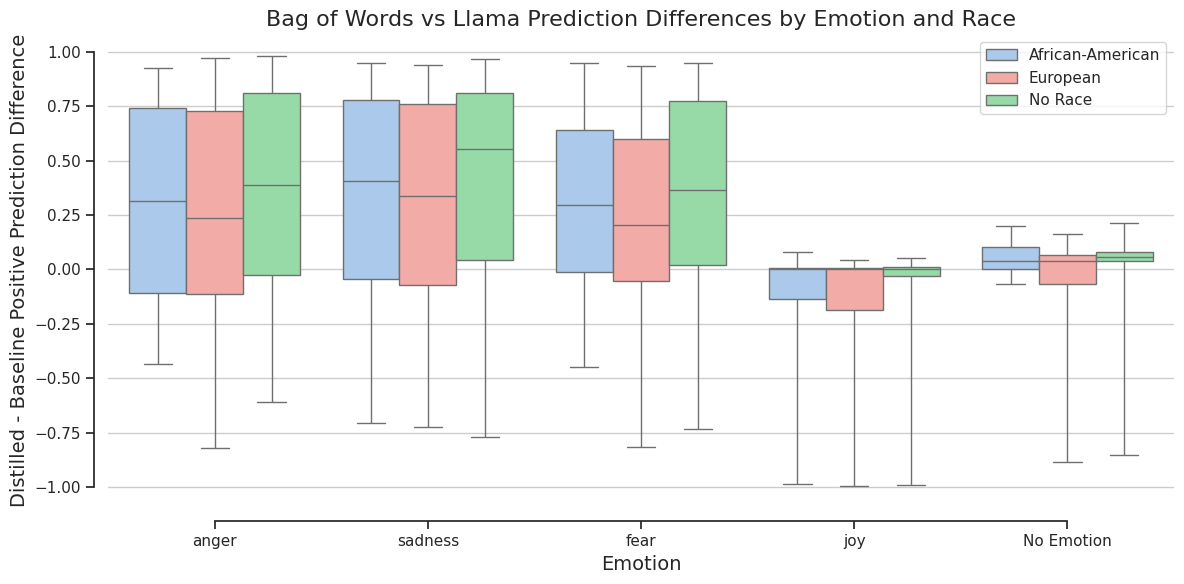

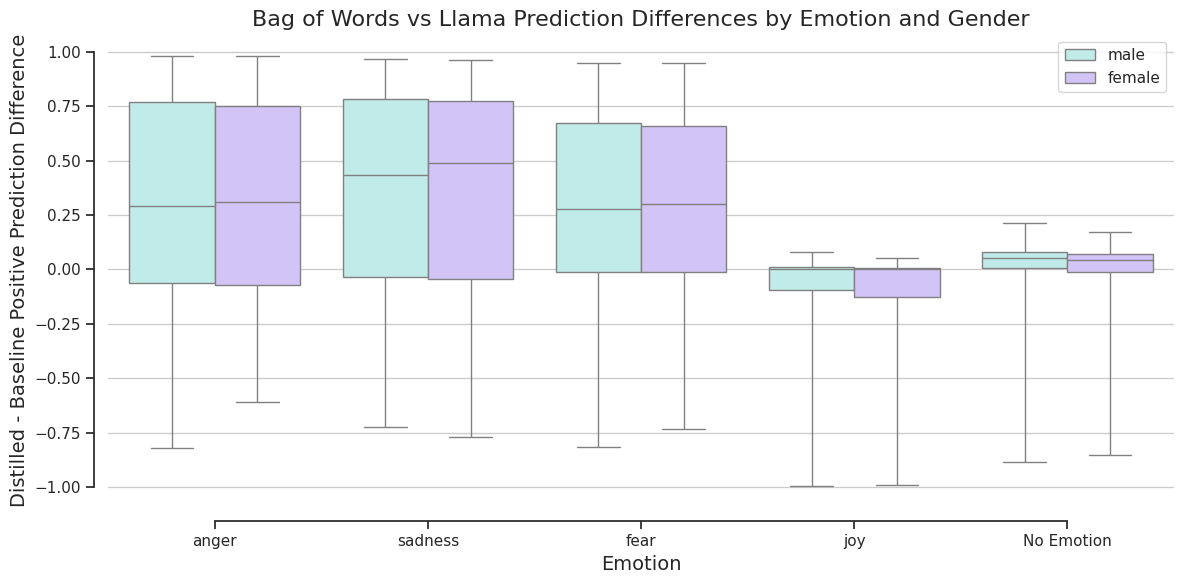

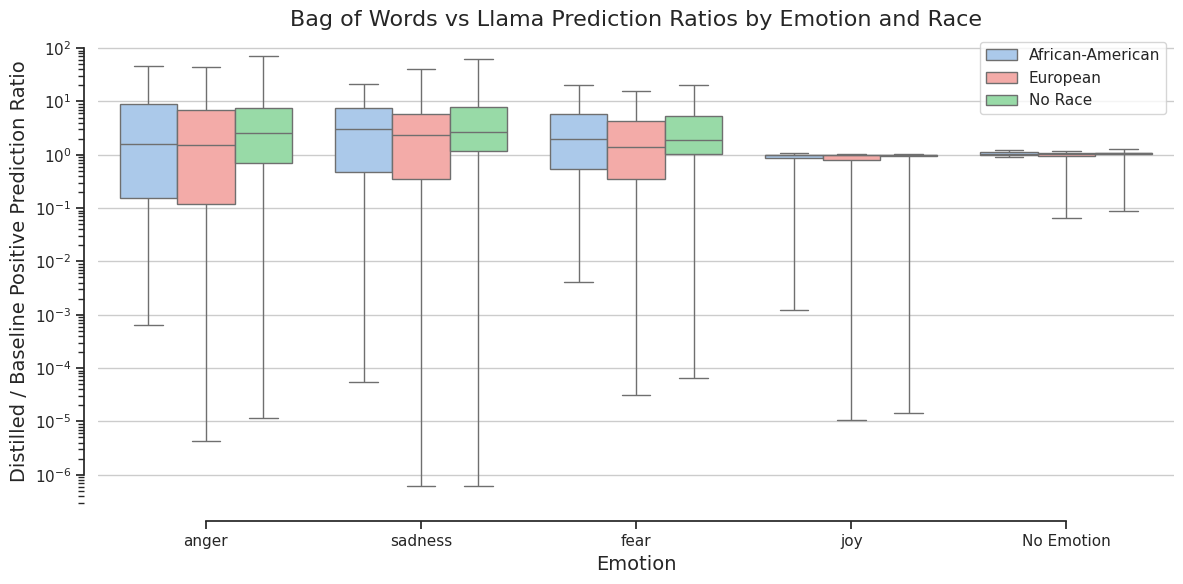

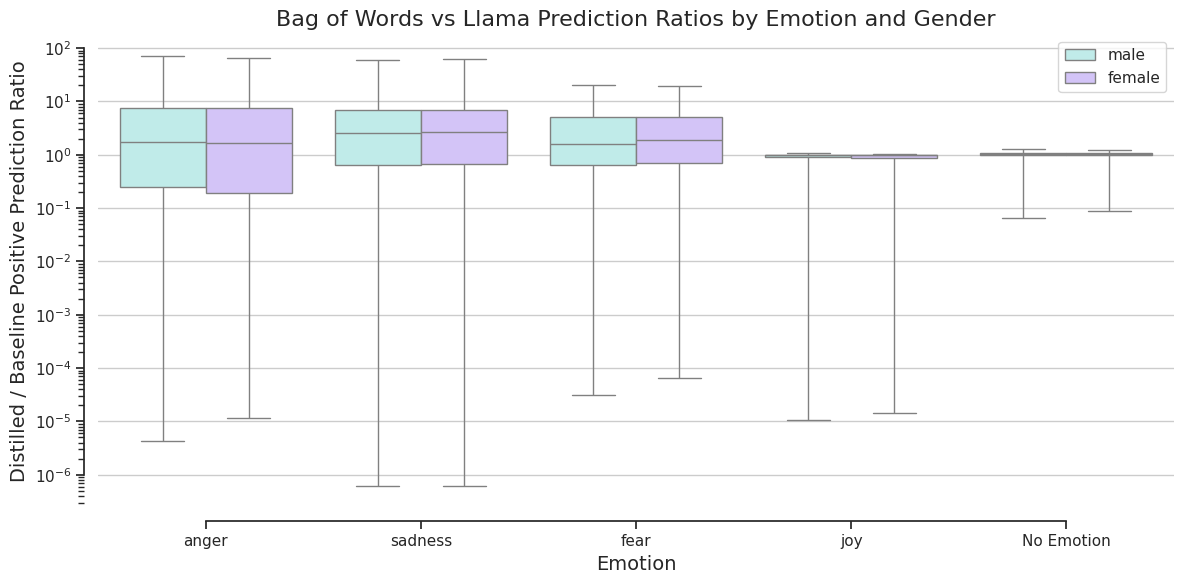

In [19]:
# Get differences between llama and bow distilled
ds['llama_bow_diff'] = (ds['bow_distilled'] - ds['llama'])
ds['llama_bow_ratio'] = ds['bow_distilled'] / ds['llama']

graph_differences_by_variable(ds, "llama_bow_diff", "race", "Bag of Words vs Llama", race_palette, "graphs/llama_vs_bow_distilled_differences_by_emotion_and_race.png")
graph_differences_by_variable(ds, "llama_bow_diff", "gender", "Bag of Words vs Llama", gender_palette, "graphs/llama_vs_bow_distilled_differences_by_emotion_and_gender.png")

graph_ratios_by_variable(ds, "llama_bow_ratio", "race", "Bag of Words vs Llama", race_palette, "graphs/llama_vs_bow_distilled_ratios_by_emotion_and_race.png")
graph_ratios_by_variable(ds, "llama_bow_ratio", "gender", "Bag of Words vs Llama", gender_palette, "graphs/llama_vs_bow_distilled_ratios_by_emotion_and_gender.png")

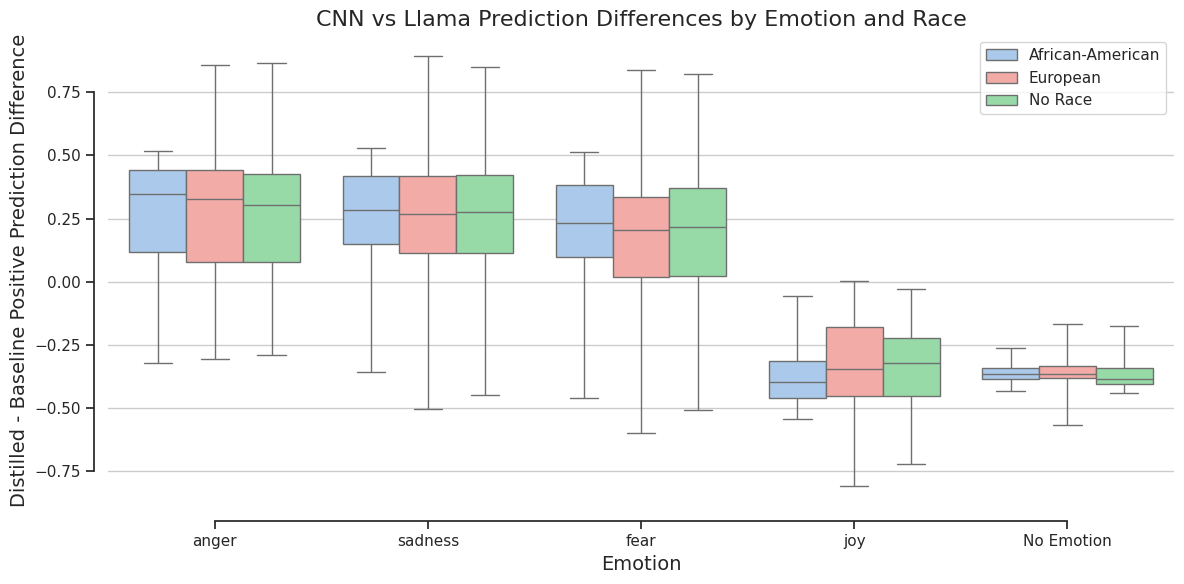

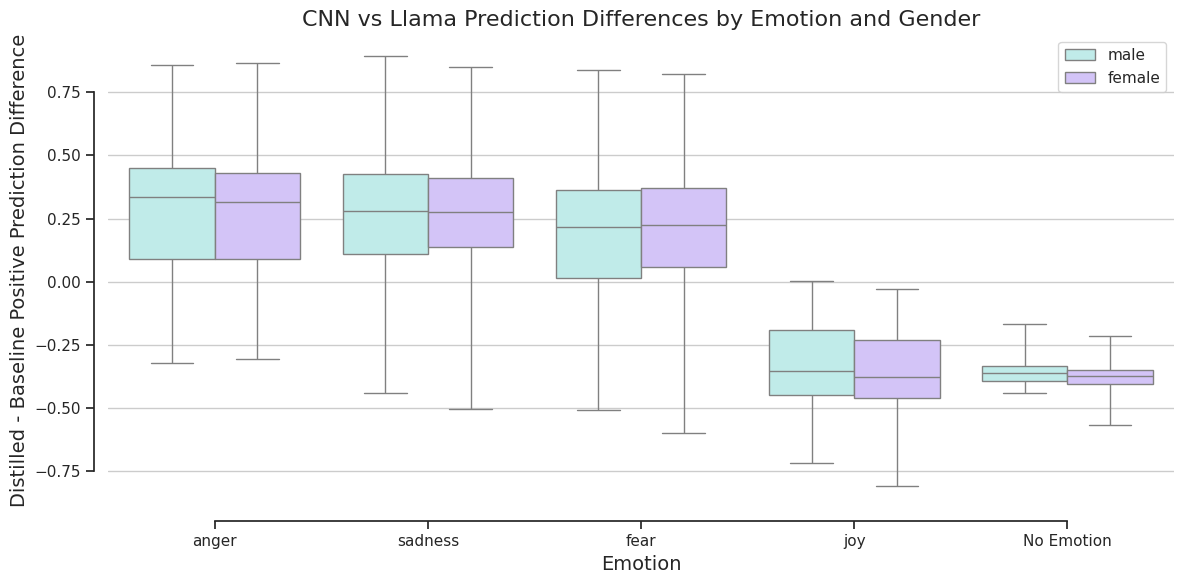

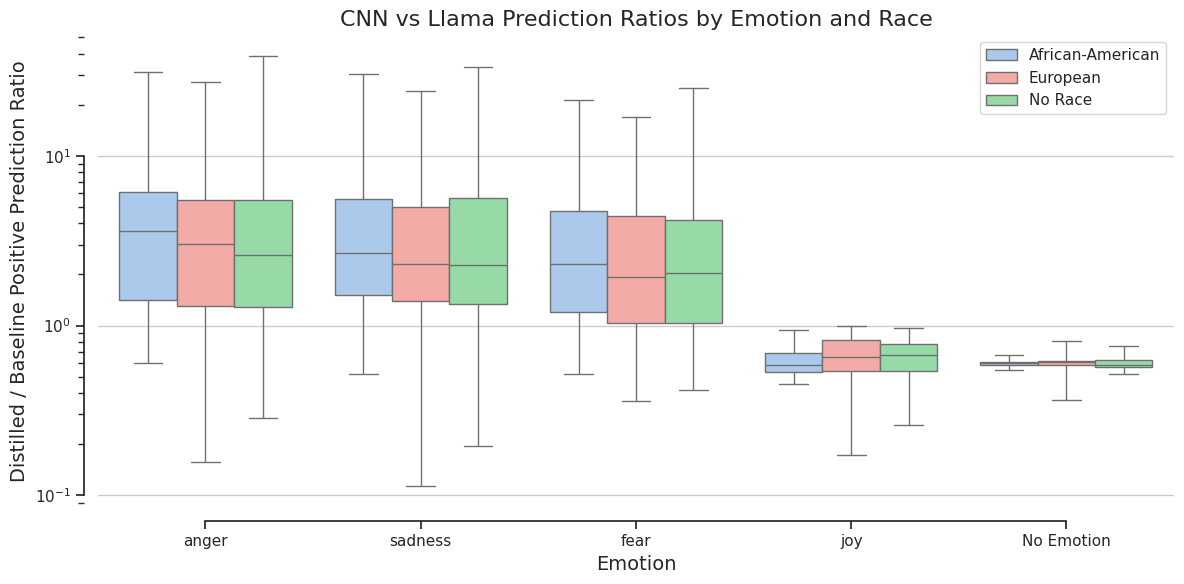

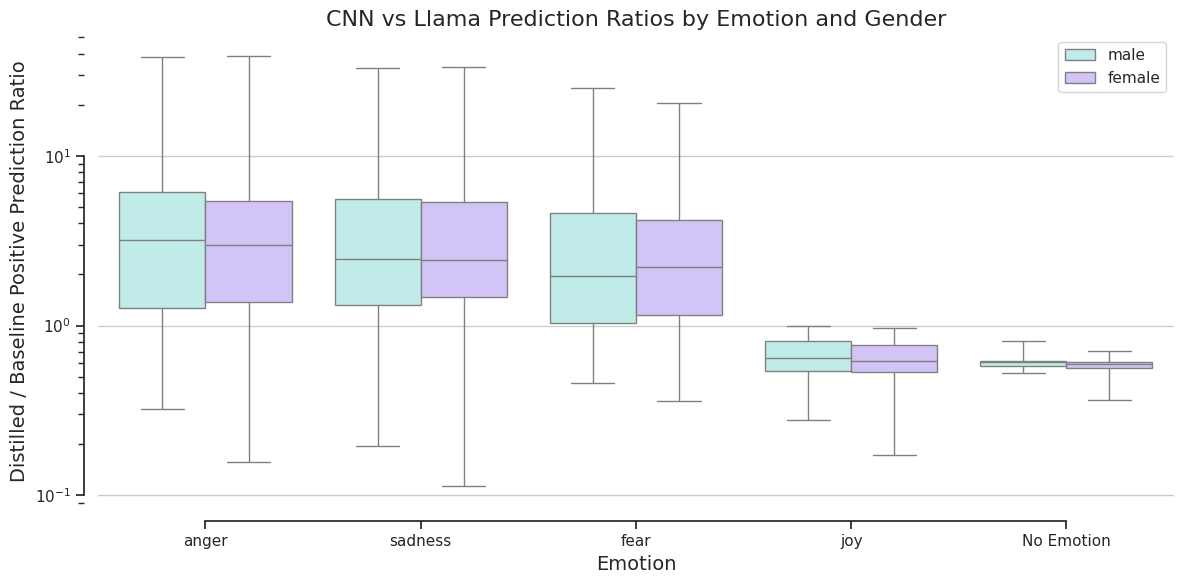

In [20]:
# Get differences between llama and cnn distilled
ds['llama_cnn_diff'] = (ds['cnn_distilled'] - ds['llama'])
ds['llama_cnn_ratio'] = ds['cnn_distilled'] / ds['llama']

graph_differences_by_variable(ds, "llama_cnn_diff", "race", "CNN vs Llama", race_palette, "graphs/llama_vs_cnn_distilled_differences_by_emotion_and_race.png")
graph_differences_by_variable(ds, "llama_cnn_diff", "gender", "CNN vs Llama", gender_palette, "graphs/llama_vs_cnn_distilled_differences_by_emotion_and_gender.png")

graph_ratios_by_variable(ds, "llama_cnn_ratio", "race", "CNN vs Llama", race_palette, "graphs/llama_vs_cnn_distilled_ratios_by_emotion_and_race.png")
graph_ratios_by_variable(ds, "llama_cnn_ratio", "gender", "CNN vs Llama", gender_palette, "graphs/llama_vs_cnn_distilled_ratios_by_emotion_and_gender.png")

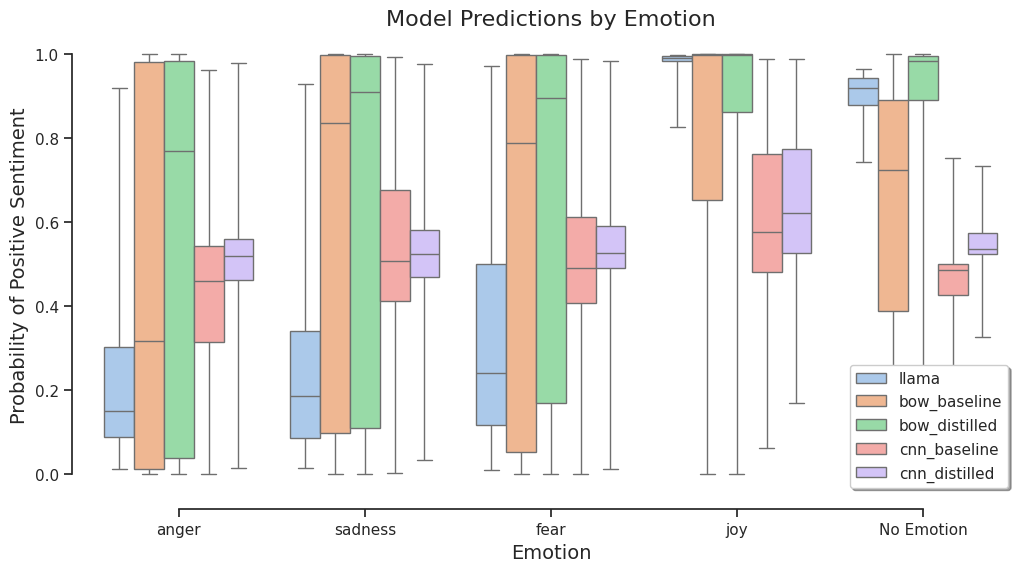

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

baseline_models = ds_model_cols['model'].str.endswith('baseline') | (ds_model_cols['model'] == 'llama')

sns.boxplot(
    x="emotion", y="prediction",
    hue="model", #palette=["m", "g", 'b'],
    data=ds_model_cols,#[baseline_models],
    whis=(0, 100),
    ax=ax
)

sns.despine(offset=10, trim=True)

ax.legend(fancybox=True, shadow=True)#loc='lower right')

ax.set_title("Model Predictions by Emotion", fontsize=16)
ax.set_xlabel("Emotion", fontsize=14)
ax.set_ylabel("Probability of Positive Sentiment", fontsize=14)

fig.savefig("graphs/model_predictions_by_emotion.png", dpi=300)

plt.show()